# DEEP NLP - Trabalho Final
## Detecção da mudança de assunto em uma conversa através da análise da representação vetorial em janela deslizante

#### Autoria
> Arthur Iperoyg {iperoyg} at {dcc.ufmg.br, gmail.com}

> Disciplina de Deep NLP em 2019/2

## Motivação
- Aumento do uso de interfaces conversacionais, em especial o Whatsapp no Brasil
- Estamos na era dos Chatbots, em que cada empresa precisará estar presente em pelo menos um canal de mensageria e isso só será escalável utilizando tecnologias como chatbots.
- A tese dos Contatos Inteligentes reforça isso, indicando que as pessoas irão estabelecer relações com as empresas através de um contato desta no aplicativo de mensageria delas.
- Thread Infinita: Uma conversa, vários assuntos. A teoria da Thread Infinita diz que, na relação da pessoa com o contato inteligente da marca (empresa), a pessoa terá uma conversa sobre todos os assuntos pertinentes da relação entre ela e a marca.
- E essa realidade nos motiva pensar como analisar as conversas através de assuntos

## Problema
**Analisar threads de conversa infinitas**
Sendo que:
- Assunto: Agrupamento de uma sequência de mensagens
Assim, queremos:
- Realizar detecção de assuntos, através de uma **Representação da Conversa em Janela Deslizante**

## PERGUNTA: "É possível detectar a mudança de assunto  de uma conversa através da análise de mudanças da representação em janela deslizante?"

## Base de Dados
- Amostra de uma base de conversas da Take
- Uma conversa é composta por mensagens; Uma mensagem é composta de: Quando (Timestamp), Por quem (String), Para Quem (String), O quê (String).
- O acesso e uso dos dados respeitou a LGPD:
    - Amostra de 3 meses de 3 clientes (dados anonimizados)
    - 4MM de mensagens e  300 mil conversas

A representação vetorial das conversas foi realizada utilizando ***Doc2Vec* do GENSIM**
Para as análises realizadas neste trabalho, foram consideradas apenas as conversas com mais de 100 mensagens trocadas

### Bibliotecas necessárias para execução do trabalho

In [169]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

import pandas as pd
import numpy as np

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt
from scipy import spatial

from tqdm import tqdm

import statistics
import seaborn

### Obtenção dos dados

Neste trabalho foram utilizados dados conversacionais 

In [2]:
conversation_df = pd.read_pickle("data/conversation_data_1.pkl")

## Análises

Abaixo serão apresentadas as análises realizadas utilizando T-SNE e comparações vetoriais

### Comparações vetoriais

Uma das formas de se analizar as conversas é através do comportamento de seus vetores de representação. Neste trabalho, dividimos as conversas em pedaços ou chunks usando uma janela deslizante de tamanho fixo. Dessa forma, para uma conversa com 7 mensagens trocadas entre chatbot e pessoa, e considerando uma janela deslizante de tamanho 4, temos:

- **M** = {M1, M2, M3, M4, M5, M6, M7} = Conjunto de mensagens, ordenadas pela data e hora de registro da mesma.
- **C(M, 4)** = { [M1,M2,M3,M4], [M2,M3,M4,M5], [M3,M4,M5,M6], [M4,M5,M6,M7] } = Conjunto de chunks gerados de **M** e de uma *janela deslizante* de tamanho 4 

Cada item no conjunto C(M,4) tem sua representação vetorial, como podemos ver no exemplo abaixo:

In [28]:
conversation_id = 0
print('Número de chunks na conversa', conversation_id, ':', len(conversation_df[conversation_df["new_id"]==conversation_id]))
#print('Número médio de chunks nos dados :', conversation_df.groupby("new_id").count())
print('Tamanho dos vetores de representação do chunk :', len(conversation_df["doc2vec"].iloc[0][0]))

Número de chunks na conversa 0 : 105
Tamanho dos vetores de representação do chunk : 300


#### Análise de mudança de posição
Como temos vetores representando cada chunk e existe uma relação temporal entre eles, podemos interpretar a conversa como uma partícula que está navegando no espaço de assuntos. Cada chunk representa o estado da conversa neste espaço e a sequência de chunks representa a movimentação dessa particula no espaço.

In [130]:
def calculate_sequential_position_change(doc2vec_series):
    li = doc2vec_series
    return [spatial.distance.cosine(li.iloc[i], li.iloc[i+1]) for i in range(len(li)-1)] 

In [134]:
grouped_conversation_df = conversation_df.groupby("new_id")

In [138]:
aggregations = {'doc2vec': [calculate_sequential_position_change]}
df = grouped_conversation_df.agg(aggregations)

In [147]:
df.columns = (df.columns.map('_'.join))

In [164]:
df['max'] = df['doc2vec_calculate_sequential_position_change'].apply(lambda x : max(x))
df['min'] = df['doc2vec_calculate_sequential_position_change'].apply(lambda x : min(x))
df['mean'] = df['doc2vec_calculate_sequential_position_change'].apply(lambda x : statistics.mean(x))
df['std'] = df['doc2vec_calculate_sequential_position_change'].apply(lambda x : statistics.stdev(x))
df['chunks_number'] = df['doc2vec_calculate_sequential_position_change'].apply(lambda x : len(x)+1)

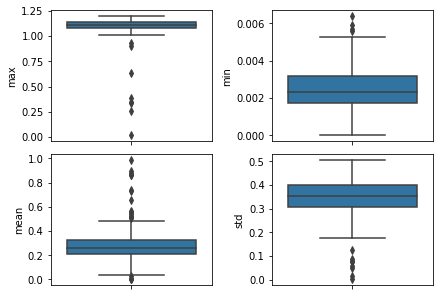

In [188]:
fig, axs = plt.subplots(2, 2, constrained_layout=True)
seaborn.boxplot(df['max'], orient="v", ax=axs[0,0])
seaborn.boxplot(df['min'], orient="v", ax=axs[0,1])
seaborn.boxplot(df['mean'], orient="v", ax=axs[1,0])
seaborn.boxplot(df['std'], orient="v", ax=axs[1,1])

#### Resultado da Análise de mudança de posição.
Conseguimos observar nos gráficos *"boxplot"* gerados acima que as conversas analisadas possuem todas comportamentos similares:

- Em sua grande maioria, a distância sequencial máxima (gráfico max) está entre 1.25 e 1.00.
- Em sua grande maioria, a média dessa mesma distância (gráfico mean) está entre 0.10 e 0.50.

Apesar de serem análises iniciais, esses números ajudam a reforçar a hipótese de que as conversas permanecem em um contexto (média entre 0.2 e 0.4) e algumas vezes tem saltos de assuntos (valores máximos = 1).

Se considerarmos essa hipótese, podemos analisar quantas possíveis mudanças de assuntos ocorreram em uma conversa.

#### Quantidade mudanças de assuntos em uma conversa, considerando a ocorrência de valores máximos

In [205]:
df['max_occour'] = df['doc2vec_calculate_sequential_position_change'].apply(lambda x : len([i for i in x if i>=1.0]))

In [206]:
df['max_occour'].describe()

count    161.000000
mean      19.863354
std       55.049125
min        0.000000
25%        6.000000
50%       10.000000
75%       19.000000
max      644.000000
Name: max_occour, dtype: float64

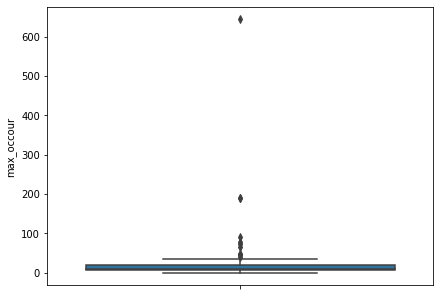

In [210]:
fig, axs = plt.subplots(1, constrained_layout=True)
seaborn.boxplot(df['max_occour'], orient="v")

Os resultados acima nos mostram que, em médica, ocorrem 19 += 55 trocas de assuntos em uma conversa, nesta base de dados. Em um primeiro momentos os valores podem parecer altos, mas considerando que a base tem dados espaçados no tempo e, tem no mínimo 100 mensagens, as valores fazem um pouco mais de sentido.
Além disso, no gráfico abaixo plotamos a relação entre a "ocorrência de troca de assunto" (coluna max_occour) e a quantidade chunks, o que indica indiretamente, o "tamanho da conversa". Podemos ver que aparenta existir uma alguma correlação entre as variáveis, o que faz sentido do ponto de vista lógico: quanto maior a conversa, mais oportunidades para a troca de assunto. 

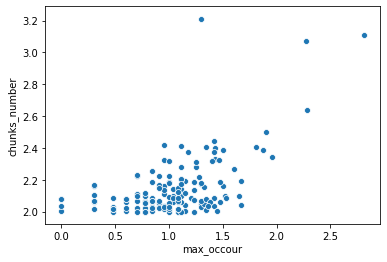

In [217]:
seaborn.scatterplot(np.log10(df['max_occour']), np.log10(df['chunks_number']))

### Análises qualitativas

In [243]:
def get_for_plot(chunks, column_id="new_id", n_c = 2):
    
    tsne = TSNE(n_components=n_c, perplexity=3, n_iter=2000, random_state=13)
    reducer = umap.UMAP(random_state=13)
    
    dim_array = np.concatenate([x for x in conversation_df['doc2vec'].values], axis=0)
    plots = list()
    id_list = list()
    time_list = list()
    id_list2 = list()
    time_list2 = list()
    actual = None
    acc = 0
    acc2 = 0
    chunks_list = list(chunks[column_id].values)
    for index, i in enumerate(tqdm(chunks_list)):
        if actual is None or actual != i:
            if len(id_list2) > 0:
                #dim_reduction = tsne.fit_transform(dim_array[index-len(id_list2):index])
                dim_reduction = reducer.fit_transform(dim_array[index-len(id_list2):index])
                plots.append( (id_list2, time_list2, dim_reduction) )
            id_list2 = list()
            time_list2 = list()
            actual = i
            acc2=0
            acc+=1
        acc2 +=1
        id_list.append(acc)
        time_list.append(acc2)
        id_list2.append(acc)
        time_list2.append(acc2)
    index = len(list(chunks[column_id].values))
    #dim_reduction = tsne.fit_transform(dim_array[index-len(id_list2):index])
    dim_reduction = reducer.fit_transform(dim_array[index-len(id_list2):index])
    plots.append( (id_list2, time_list2, dim_reduction) )
    dim_results = tsne.fit_transform(dim_array)
    return plots, id_list, time_list, dim_results

In [244]:
filtered_conversation_df = conversation_df[conversation_df["new_id"].isin([0,50,100])]

In [ ]:
plots1d, idl1, tl1, plot1full = get_for_plot(filtered_conversation_df, "new_id", 1)

100%|██████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 773.36it/s]


In [ ]:
plots2d, idl2, tl2, plot2full = get_for_plot(filtered_conversation_df, "new_id", 2)

In [ ]:
chunks_list = [x for x in conversation_df['doc2vec'].values]
chunks_distances = [(spatial.distance.cosine(chunks_list[i], chunks_list[i+1])) for i in range(0, len(chunks_list)-1)]
len(chunks_list)

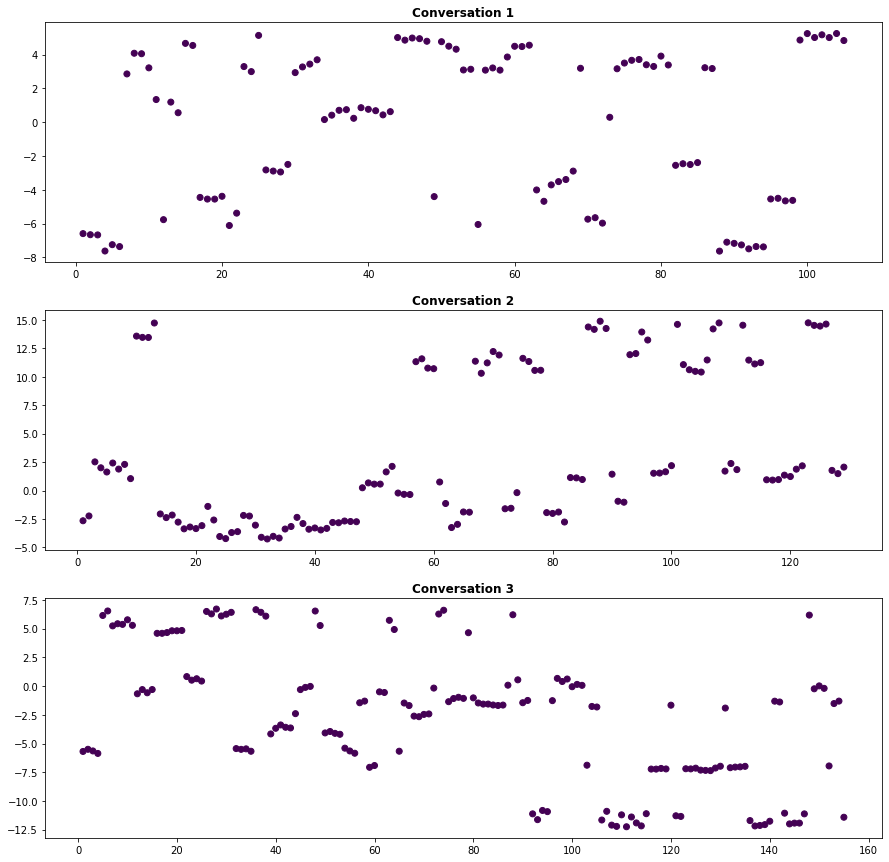

In [238]:
f, ax = plt.subplots(3,figsize=(15,15))
for i, plot in enumerate(plots1d):
    id_list = plot[0]
    time_list = plot[1]
    tsne_results = plot[2]
    ax[i].scatter(time_list, tsne_results[:,0], c=id_list, cmap="viridis")
    ax[i].set_title("Conversation " + str(i+1), fontweight='bold')
  #display(f)

#ax[3].scatter(tsne1[:,0], tsne1[:,0], c=idl1, cmap="viridis")
#ax[3].set_title("Conversations", fontweight='bold')
#display(f)

### Resultados da análise qualitativa
Resultados pouco conclusivos, mas que indicam grupos de assuntos nas conversas expostas acima. 

# Conclusões e Próximos passos
- Muitos problemas na metodologia e nos dados
- Muito espaço para aprofundar na pesquisa
- Treinar a rede CNN1d
- Definir metologia e gerar o dado “rotulado”
- Melhorar o tratamento na base dados e aumentar o volume dos dados
- Avaliar diferentes estratégias para uso da janela deslizante